In [1]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available ? :  True


In [2]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [12]:
with open('../../Data/movie_201118_table_6_10.pickle', 'rb') as f:
    data = pickle.load(f)

In [13]:
data = data[['sa_id', 'album_id', 'label']]

In [14]:
sparse_features = ['sa_id', 'album_id'
#                    , 'buy_seg'
                  ]
dense_features = ['release_date', 'run_time', 'movie_meta_price', 'i30_meta_price', 'buy_tot',
                  'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4']
target = ['label']

In [15]:
lbe_dict = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    lbe.fit(data[feat])
    data[feat] = lbe.transform(data[feat])
    lbe_dict[feat] = lbe
    
mms = MinMaxScaler(feature_range=(0, 1))
# data[dense_features] = mms.fit_transform(data[dense_features])

In [16]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [18]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [20]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=2**18, epochs=200, verbose=1, validation_split=0.2,
                   callbacks=[callback])

Epoch 1/200


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


210/210 [==============================] - 7s 34ms/step - loss: 0.2423 - binary_crossentropy: 0.2399 - val_loss: 0.1596 - val_binary_crossentropy: 0.1573
Epoch 2/200
210/210 [==============================] - 7s 32ms/step - loss: 0.1575 - binary_crossentropy: 0.1536 - val_loss: 0.1547 - val_binary_crossentropy: 0.1495
Epoch 3/200
210/210 [==============================] - 7s 33ms/step - loss: 0.1504 - binary_crossentropy: 0.1438 - val_loss: 0.1497 - val_binary_crossentropy: 0.1425
Epoch 4/200
210/210 [==============================] - 7s 32ms/step - loss: 0.1457 - binary_crossentropy: 0.1370 - val_loss: 0.1486 - val_binary_crossentropy: 0.1393
Epoch 5/200
210/210 [==============================] - 7s 32ms/step - loss: 0.1415 - binary_crossentropy: 0.1310 - val_loss: 0.1475 - val_binary_crossentropy: 0.1369
Epoch 6/200
210/210 [==============================] - 7s 32ms/step - loss: 0.1374 - binary_crossentropy: 0.1259 - val_loss: 0.1470 - val_binary_crossentropy: 0.1354
Epoch 7/200
210/

In [21]:
pred_ans = model.predict(test_model_input, batch_size=2**16)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.1332
test AUC 0.9609


In [22]:
import matplotlib.pyplot as plt

(array([14112287.,   676546.,   400149.,   300897.,   257024.,   240884.,
          243513.,   260318.,   293419.,   344460.]),
 array([6.8277251e-07, 9.9728346e-02, 1.9945601e-01, 2.9918367e-01,
        3.9891133e-01, 4.9863899e-01, 5.9836668e-01, 6.9809431e-01,
        7.9782200e-01, 8.9754963e-01, 9.9727732e-01], dtype=float32),
 <a list of 10 Patch objects>)

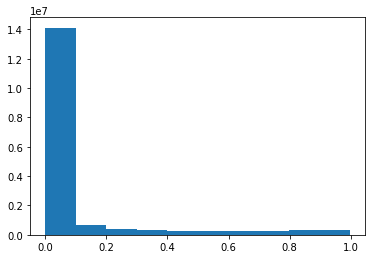

In [23]:
plt.hist(pred_ans)

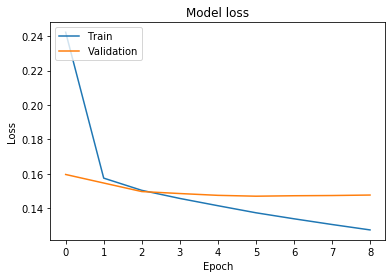

In [27]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
y_pred = pred_ans.round()

In [39]:
conf = confusion_matrix(test[target], y_pred)
print(conf)

[[15195410   375264]
 [  554841  1003982]]


In [42]:
report = classification_report(test[target], y_pred, target_names=['0', '1'])
report_dict = classification_report(test[target], y_pred, target_names=['0', '1'], output_dict = True)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97  15570674
           1       0.73      0.64      0.68   1558823

    accuracy                           0.95  17129497
   macro avg       0.85      0.81      0.83  17129497
weighted avg       0.94      0.95      0.94  17129497



In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets
